In [1]:
%matplotlib inline

In [2]:
from io import open
import glob
import os
import unicodedata
import string

import torch
import torch.nn as nn

import numpy as np
import pandas as pd
import scipy as sc

from sklearn.preprocessing import MinMaxScaler

import matplotlib.pyplot as plt

from sklego.preprocessing import RepeatingBasisFunction
from sklearn.preprocessing import FunctionTransformer


from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import FunctionTransformer
from sklearn.metrics import mean_absolute_error
from sklego.preprocessing import RepeatingBasisFunction


# Cuda

In [3]:
# Check if CUDA (GPU support) is available
if torch.cuda.is_available():
    # Get the name of the GPU device
    device = torch.device("cuda")
    print("GPU is available")
    print("Using GPU:", torch.cuda.get_device_name(0))
else:
    device = torch.device("cpu")
    print("GPU is not available, using CPU")

GPU is not available, using CPU


/home/marcel/Documents/PyTorch/.venv/lib/python3.11/site-packages/torch/cuda/__init__.py:138: UserWarning: CUDA initialization: CUDA unknown error - this may be due to an incorrectly set up environment, e.g. changing env variable CUDA_VISIBLE_DEVICES after program start. Setting the available devices to be zero. (Triggered internally at ../c10/cuda/CUDAFunctions.cpp:108.)
  return torch._C._cuda_getDeviceCount() > 0


# Prepare data

In [4]:
energy_dataset = pd.read_csv("./energy_dataset.csv").sort_values(by='time', ascending=True)
weather_features = pd.read_csv("./weather_features.csv").sort_values(by='dt_iso', ascending=True)

In [5]:
weather_features["city_name"].unique()

array(['Valencia', 'Madrid', 'Bilbao', ' Barcelona', 'Seville'],
      dtype=object)

In [6]:
energy_dataset.columns

Index(['time', 'generation biomass', 'generation fossil brown coal/lignite',
       'generation fossil coal-derived gas', 'generation fossil gas',
       'generation fossil hard coal', 'generation fossil oil',
       'generation fossil oil shale', 'generation fossil peat',
       'generation geothermal', 'generation hydro pumped storage aggregated',
       'generation hydro pumped storage consumption',
       'generation hydro run-of-river and poundage',
       'generation hydro water reservoir', 'generation marine',
       'generation nuclear', 'generation other', 'generation other renewable',
       'generation solar', 'generation waste', 'generation wind offshore',
       'generation wind onshore', 'forecast solar day ahead',
       'forecast wind offshore eday ahead', 'forecast wind onshore day ahead',
       'total load forecast', 'total load actual', 'price day ahead',
       'price actual'],
      dtype='object')

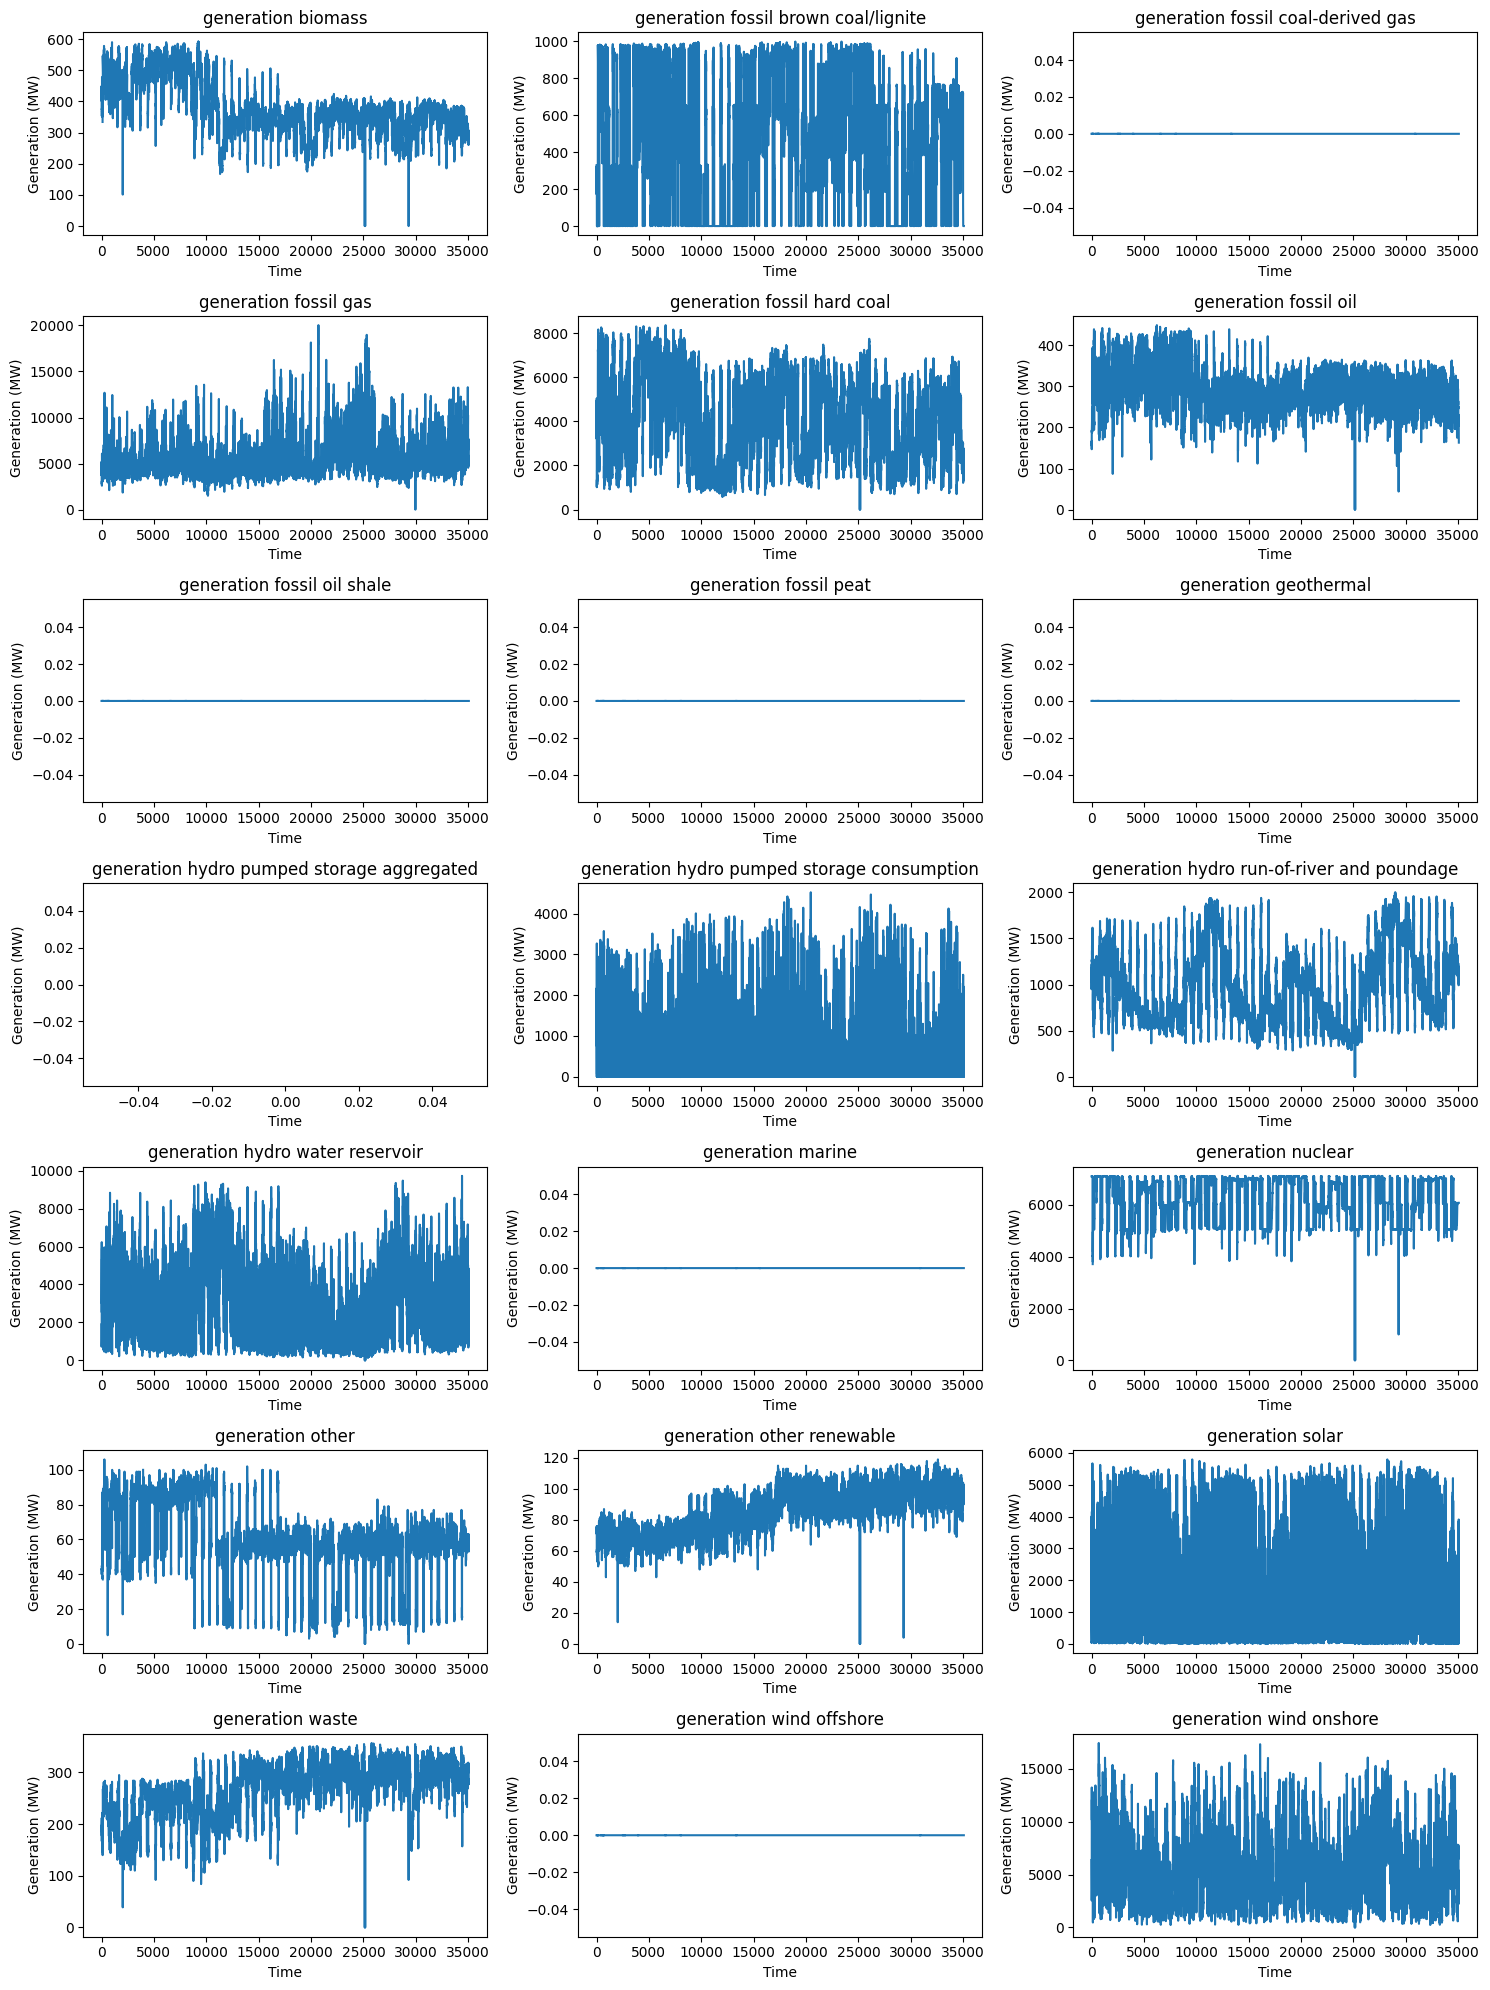

In [7]:
columns_to_plot = ['generation biomass', 'generation fossil brown coal/lignite',
                   'generation fossil coal-derived gas', 'generation fossil gas',
                   'generation fossil hard coal', 'generation fossil oil',
                   'generation fossil oil shale', 'generation fossil peat',
                   'generation geothermal', 'generation hydro pumped storage aggregated',
                   'generation hydro pumped storage consumption',
                   'generation hydro run-of-river and poundage',
                   'generation hydro water reservoir', 'generation marine',
                   'generation nuclear', 'generation other', 'generation other renewable',
                   'generation solar', 'generation waste', 'generation wind offshore',
                   'generation wind onshore']

# Plotting each selected column
plt.figure(figsize=(15, 20))

for i, column in enumerate(columns_to_plot, 1):
    plt.subplot(7, 3, i)
    plt.plot(energy_dataset[column])
    plt.title(column)
    plt.xlabel('Time')
    plt.ylabel('Generation (MW)')
    plt.tight_layout()

plt.show()

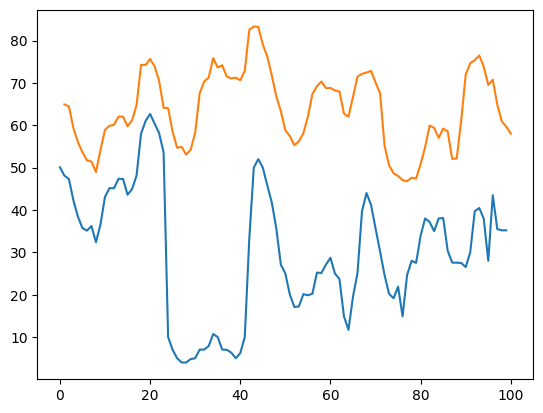

In [8]:
length = 0
plt.plot(energy_dataset['price day ahead'][length : length + 100])
plt.plot(energy_dataset['price actual'][length + 1 : length + 101])

plt.show()

In [9]:
def sin_transformer(period):
	return FunctionTransformer(lambda x: np.sin(x / period * 2 * np.pi))

def cos_transformer(period):
	return FunctionTransformer(lambda x: np.cos(x / period * 2 * np.pi))



def prepareData(inputData):

    inputData['time'] = pd.to_datetime(inputData['time'], utc=True)

    X_2 = inputData.copy()

    X_2["month"] = X_2.time.dt.month
    X_2["day_of_year"] = X_2.time.dt.day_of_year
    X_2["hour"] = X_2.time.dt.hour

    X_2["month_sin"] = np.sin(2 * np.pi * X_2["month"]/12.0)
    X_2["month_cos"] = np.cos(2 * np.pi * X_2["month"]/12.0)

    X_2["day_sin"] = np.sin(2 * np.pi * X_2["day_of_year"]/365.0)
    X_2["day_cos"] = np.cos(2 * np.pi * X_2["day_of_year"]/365.0)

    X_2["hour_sin"] = np.sin(2 * np.pi * X_2["hour"]/24.0)
    X_2["hour_cos"] = np.cos(2 * np.pi * X_2["hour"]/24.0)

    return X_2[ ["month_sin", "month_cos", "day_sin", "day_cos", "hour_sin", "hour_cos", ] ]

In [10]:
length = int( 0.8 * len(energy_dataset) )

df_train = energy_dataset.iloc[0 : length].copy()
df_test = energy_dataset.iloc[length : -1].copy()

df_test.index = df_test.index.factorize()[0]

In [11]:
columns_to_scale = ['generation biomass', 'generation fossil brown coal/lignite',
                    'generation fossil gas',
                   'generation fossil hard coal', 'generation fossil oil',
                   'generation hydro pumped storage consumption',
                   'generation hydro run-of-river and poundage',
                   'generation hydro water reservoir', 
                   'generation nuclear', 'generation other', 'generation other renewable',
                   'generation solar', 'generation waste', 
                   'generation wind onshore',
                   'price actual']

time_column = prepareData(df_train).copy()
df = df_train[columns_to_scale].copy()

scaler = MinMaxScaler()
df_scaled = pd.DataFrame(scaler.fit_transform(df), columns=columns_to_scale)

df_scaled[time_column.columns] = time_column
df_scaled = df_scaled[list( time_column.columns ) + columns_to_scale] 


df_train = df_scaled.dropna().copy()

In [12]:
price_pred = df_test.copy()
price_pred['price actual'] = price_pred["price day ahead"] 
price_pred = price_pred[columns_to_scale].dropna()

In [13]:
time_column = prepareData(df_test).copy()
df = df_test[columns_to_scale].copy()


df_scaled = pd.DataFrame(scaler.transform(df), columns=columns_to_scale)


df_scaled[time_column.columns] = time_column
df_scaled = df_scaled[list( time_column.columns ) + columns_to_scale] 


df_test = df_scaled.dropna().copy()

In [14]:

price_pred = pd.DataFrame(scaler.transform(price_pred[columns_to_scale]), columns=columns_to_scale)[:-1]


In [15]:
price_pred = price_pred['price actual']

In [16]:
df_test

,month_sin,month_cos,day_sin,day_cos,hour_sin,hour_cos,generation biomass,generation fossil brown coal/lignite,generation fossil gas,generation fossil hard coal,...,generation hydro pumped storage consumption,generation hydro run-of-river and poundage,generation hydro water reservoir,generation nuclear,generation other,generation other renewable,generation solar,generation waste,generation wind onshore,price actual
0,1.000000e+00,6.123234e-17,9.510565e-01,0.309017,-1.000000,-1.836970e-16,0.423986,0.0,0.205282,0.127766,...,0.168251,0.953584,0.680690,0.852606,0.566038,0.886957,0.005352,0.775910,0.818135,0.387271
1,1.000000e+00,6.123234e-17,9.510565e-01,0.309017,-0.965926,2.588190e-01,0.425676,0.0,0.203824,0.134705,...,0.032943,0.939144,0.719565,0.852606,0.518868,0.878261,0.004662,0.812325,0.763134,0.468968
2,1.000000e+00,6.123234e-17,9.510565e-01,0.309017,-0.866025,5.000000e-01,0.432432,0.0,0.151221,0.126092,...,0.037143,0.955647,0.650122,0.852606,0.500000,0.895652,0.002935,0.823529,0.743863,0.386713
3,1.000000e+00,6.123234e-17,9.510565e-01,0.309017,-0.707107,7.071068e-01,0.429054,0.0,0.136585,0.115205,...,0.179306,0.955647,0.569496,0.853309,0.509434,0.904348,0.002935,0.806723,0.750746,0.340653
4,1.000000e+00,6.123234e-17,9.510565e-01,0.309017,-0.500000,8.660254e-01,0.418919,0.0,0.119248,0.102046,...,0.443732,0.941723,0.557780,0.853449,0.500000,0.826087,0.002935,0.806723,0.768984,0.197823
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7007,-2.449294e-16,1.000000e+00,6.432491e-16,1.000000,-0.965926,-2.588190e-01,0.494932,0.0,0.328095,0.311521,...,0.000221,0.583290,0.426563,0.853168,0.575472,0.800000,0.045925,0.809524,0.169305,0.635340
7008,-2.449294e-16,1.000000e+00,6.432491e-16,1.000000,-1.000000,-1.836970e-16,0.501689,0.0,0.330309,0.314392,...,0.000221,0.585353,0.515071,0.853309,0.594340,0.826087,0.014675,0.775910,0.178539,0.629850
7009,-2.449294e-16,1.000000e+00,6.432491e-16,1.000000,-0.965926,2.588190e-01,0.500000,0.0,0.309084,0.306975,...,0.000221,0.604435,0.418681,0.853449,0.584906,0.826087,0.005698,0.784314,0.188575,0.621848
7010,-2.449294e-16,1.000000e+00,6.432491e-16,1.000000,-0.866025,5.000000e-01,0.493243,0.0,0.297418,0.289748,...,0.011055,0.592058,0.301523,0.853731,0.575472,0.817391,0.005352,0.801120,0.200906,0.604541


In [17]:
#train_data = prepareData(df_train)
train_dataset = {"x": df_train.iloc[:-1].values, "y": df_train[1:][ ["price actual"] ].values.reshape((-1, 1))}

#test_data = prepareData(df_test)
test_dataset = {"x": df_test.iloc[:-1].values, "y": df_test[1:][ ["price actual"] ].values.reshape((-1, 1))}

In [20]:
import random

def randomPair(len, maxSequence):
    a = random.randint(0, len - 1 - maxSequence)
    #return (a, random.randint(a + 1, a + maxSequence))
    return (a, a + maxSequence)

In [21]:
# generating pairs so I can run same test for all NN
pairs = np.empty((0, 2), dtype=np.int64)
for i in range(0, 100000):

    pairs = np.vstack((pairs, randomPair(len(df_train), 30)))

## Creating Networks

In [22]:
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()
        self.hidden_size = hidden_size

        self.W = nn.Linear(hidden_size, hidden_size)
        self.U = nn.Linear(input_size, hidden_size)
        self.V = nn.Linear(hidden_size, output_size)

        self.dropout = nn.Dropout(0.1)
        #self.softmax = nn.Softmax(dim=1)
        self.tanh = nn.Tanh()

    def forward(self, input, hidden):

        # h_n = tanh( W*h_n-1 + U*x_n + b )
        # y_hat = softmax( V*h_n + c )
        
        inp = self.W(hidden)
        hid = self.U(input)

        hidden = inp + hid
        hidden = self.dropout(hidden)
        hidden = self.tanh(hidden)

        output = self.V(hidden)
        #print(output)
        #output = self.softmax(output)

        return output, hidden

    def initHidden(self):
        return torch.zeros(1, self.hidden_size)

In [23]:
class LTC_RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, delta, tau):
        super(LTC_RNN, self).__init__()
        self.hidden_size = hidden_size
        self.delta = delta
        self.tau = tau

        self.W = nn.Linear(hidden_size, hidden_size)
        self.U = nn.Linear(input_size, hidden_size)
        self.V = nn.Linear(hidden_size, output_size)

        self.A = nn.Linear(hidden_size, 1)


        self.dropout = nn.Dropout(0.1)
        #self.softmax = nn.Softmax(dim=1)
        self.tanh = nn.Tanh()

    def forward(self, input, hidden):

        # f_n = tanh( W*h_n-1 + U*x_n + b )
        # h_n = ( h_n-1 + delta*f_n*A ) / ( 1 + delta*(1/tau + f_n) )
        # y_hat = softmax( V*h_n + c )
        
        inp = self.W(hidden)
        hid = self.U(input)

        f_n = inp + hid
        f_n = self.dropout(f_n)
        f_n = self.tanh(f_n)

        h_n = (hidden + self.delta * self.A(f_n)) / (1 + self.delta * (1/self.tau + f_n))

        output = self.V(h_n)
        #print(output)
        #output = self.softmax(output)

        return output, h_n

    def initHidden(self):
        return torch.zeros(1, self.hidden_size)

In [24]:
class LTC_RNN3(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, delta, tau):
        super(LTC_RNN3, self).__init__()
        self.hidden_size = hidden_size
        self.delta = delta
        self.tau = tau

        self.W = nn.Linear(hidden_size, hidden_size)
        self.U = nn.Linear(input_size, hidden_size)

        self.W1 = nn.Linear(hidden_size, hidden_size)
        self.U1 = nn.Linear(input_size, hidden_size)

        self.W2 = nn.Linear(hidden_size, hidden_size)
        self.U2 = nn.Linear(input_size, hidden_size)

        self.V = nn.Linear(hidden_size, output_size)

        self.A = nn.Linear(hidden_size, 1)
        self.A1 = nn.Linear(hidden_size, 1)
        self.A2 = nn.Linear(hidden_size, 1)


        self.dropout = nn.Dropout(0.1)
        #self.softmax = nn.Softmax(dim=1)
        self.tanh = nn.Tanh()

    def forward(self, input, hidden):

        # f_n = tanh( W*h_n-1 + U*x_n + b )
        # h_n = ( h_n-1 + delta*f_n*A ) / ( 1 + delta*(1/tau + f_n) )
        # y_hat = softmax( V*h_n + c )


        hid = self.W(hidden)
        i_0 = self.U(input)

        f_1 = self.f(hid, i_0)
        h_1 = self.h(hidden, f_1, self.A)


        hid = self.W1(h_1)
        i_1 = self.U1(input)

        f_2 = self.f(hid, i_1)
        h_2 = self.h(h_1, f_2, self.A1)


        hid = self.W2(h_2)
        i_2 = self.U2(input)

        f_3 = self.f(hid, i_2)
        h_3 = self.h(h_2, f_3, self.A2)

        output = self.V(h_3)
        hidden = h_3

        #print(output)
        #output = self.softmax(output)

        return output, hidden
    
    def f(self, hidden, input):

        f_n = hidden + input
        f_n = self.dropout(f_n)
        f_n = self.tanh(f_n)

        return f_n
    
    def h(self, hidden, f_n, A):
        return (hidden + self.delta * A(f_n)) / (1 + self.delta * (1/self.tau + f_n))

    def initHidden(self):
        return torch.zeros(1, self.hidden_size)

In [28]:
import time
import math

def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

## Training

In [27]:
import torch.optim as optim

criterion = nn.MSELoss()
learning_rate = 0.0005

def train(input_tensor_batch, target_tensor_batch, rnn):
    rnn.zero_grad()
    loss = torch.Tensor([0.]).to(device)

    optimizer = optim.Adam(rnn.parameters(), lr=learning_rate)


    for i in range(len(input_tensor_batch)):
        input_line_tensor = input_tensor_batch[i]
        target_line_tensor = target_tensor_batch[i]

        hidden = rnn.initHidden().to(device)
        batch_loss = torch.Tensor([0.]).to(device)

        for j in range(len(input_line_tensor)):
            output, hidden = rnn(input_line_tensor[j], hidden)
            l = criterion(output, target_line_tensor[j])
            batch_loss += l

        loss += batch_loss / len(input_line_tensor)

    loss.backward()

    optimizer.step()

    return output, loss.item() / len(input_tensor_batch)


In [29]:
train_dataset["x"] = torch.from_numpy( train_dataset["x"] ).to(torch.float32).to(device)
train_dataset["y"] = torch.from_numpy( train_dataset["y"] ).to(torch.float32).to(device)
pairs = torch.from_numpy( pairs ).to(torch.int).to(device)

In [33]:
input_size  = len( train_dataset["x"][0] )
output_size = 1 #len( train_dataset["y"][0] )
hidden_size = 40

In [35]:
rnn = RNN(input_size, hidden_size, output_size)
rnn.to(device)



n_iters = 5000
print_every = 100
plot_every = 500
all_losses = []
total_loss = 0.0  
batch_size = 10 


start = time.time()

for iter in range(1, n_iters + 1):
    batch_indices = torch.randint(0, len(train_dataset["x"]), size=(batch_size,))
    
    input_batch = [train_dataset["x"][pairs[i][0]:pairs[i][1]] for i in batch_indices]
    target_batch = [train_dataset["y"][pairs[i][0]:pairs[i][1]] for i in batch_indices]

    output, loss = train(input_batch, target_batch, rnn)
    total_loss += loss

    if iter % print_every == 0:
        print('%s (%d %d%%) %.4f' % (timeSince(start), iter, iter / n_iters * 100, loss))

    if iter % plot_every == 0:
        all_losses.append(total_loss / plot_every)
        total_loss = 0.0

/home/marcel/Documents/PyTorch/.venv/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


0m 7s (100 2%) 0.0141
0m 13s (200 4%) 0.0120
0m 20s (300 6%) 0.0086
0m 27s (400 8%) 0.0041
0m 34s (500 10%) 0.0052
0m 41s (600 12%) 0.0039
0m 47s (700 14%) 0.0039
0m 54s (800 16%) 0.0046
1m 0s (900 18%) 0.0024
1m 7s (1000 20%) 0.0027
1m 14s (1100 22%) 0.0028
1m 20s (1200 24%) 0.0021
1m 27s (1300 26%) 0.0025
1m 34s (1400 28%) 0.0023
1m 40s (1500 30%) 0.0027
1m 47s (1600 32%) 0.0023
1m 54s (1700 34%) 0.0018
2m 1s (1800 36%) 0.0020
2m 8s (1900 38%) 0.0019
2m 15s (2000 40%) 0.0021
2m 22s (2100 42%) 0.0019
2m 29s (2200 44%) 0.0021
2m 36s (2300 46%) 0.0028
2m 43s (2400 48%) 0.0021
2m 50s (2500 50%) 0.0014
2m 57s (2600 52%) 0.0018
3m 4s (2700 54%) 0.0020
3m 12s (2800 56%) 0.0014
3m 19s (2900 57%) 0.0024
3m 26s (3000 60%) 0.0017
3m 33s (3100 62%) 0.0012
3m 40s (3200 64%) 0.0014
3m 47s (3300 66%) 0.0020
3m 54s (3400 68%) 0.0021
4m 1s (3500 70%) 0.0012
4m 8s (3600 72%) 0.0016
4m 15s (3700 74%) 0.0015
4m 21s (3800 76%) 0.0015
4m 28s (3900 78%) 0.0017
4m 36s (4000 80%) 0.0016
4m 42s (4100 82%) 0.0

In [36]:
ltc_rnn = LTC_RNN(input_size, hidden_size, output_size, 1, 0.2*torch.ones(1, 1).to(device))
ltc_rnn.to(device)

n_iters = 5000
print_every = 10
plot_every = 500
all_losses = []
total_loss = 0.0  
batch_size = 10  

start = time.time()

for iter in range(1, n_iters + 1):
    batch_indices = torch.randint(0, len(train_dataset["x"]), size=(batch_size,))
    
    input_batch = [train_dataset["x"][pairs[i][0]:pairs[i][1]] for i in batch_indices]
    target_batch = [train_dataset["y"][pairs[i][0]:pairs[i][1]] for i in batch_indices]

    output, loss = train(input_batch, target_batch, ltc_rnn)
    total_loss += loss
    

    if iter % print_every == 0:
        print('%s (%d %d%%) %.4f' % (timeSince(start), iter, iter / n_iters * 100, loss))

    if iter % plot_every == 0:
        all_losses.append(total_loss / plot_every)
        total_loss = 0

0m 1s (10 0%) 0.0704
0m 2s (20 0%) 0.0504
0m 3s (30 0%) 0.0318
0m 4s (40 0%) 0.0142
0m 5s (50 1%) 0.0097
0m 6s (60 1%) 0.0164
0m 7s (70 1%) 0.0135
0m 8s (80 1%) 0.0105
0m 9s (90 1%) 0.0205
0m 10s (100 2%) 0.0176
0m 11s (110 2%) 0.0146
0m 12s (120 2%) 0.0080
0m 13s (130 2%) 0.0128
0m 14s (140 2%) 0.0053
0m 15s (150 3%) 0.0104
0m 16s (160 3%) 0.0089
0m 17s (170 3%) 0.0079
0m 18s (180 3%) 0.0102
0m 19s (190 3%) 0.0058
0m 20s (200 4%) 0.0102
0m 21s (210 4%) 0.0078
0m 22s (220 4%) 0.0097
0m 23s (230 4%) 0.0107
0m 24s (240 4%) 0.0080
0m 26s (250 5%) 0.0145
0m 27s (260 5%) 0.0116
0m 28s (270 5%) 0.0100
0m 29s (280 5%) 0.0097
0m 30s (290 5%) 0.0111
0m 31s (300 6%) 0.0096
0m 32s (310 6%) 0.0094
0m 33s (320 6%) 0.0071
0m 34s (330 6%) 0.0084
0m 35s (340 6%) 0.0129
0m 36s (350 7%) 0.0090
0m 37s (360 7%) 0.0127
0m 38s (370 7%) 0.0118
0m 39s (380 7%) 0.0117
0m 40s (390 7%) 0.0051
0m 41s (400 8%) 0.0041
0m 42s (410 8%) 0.0066
0m 43s (420 8%) 0.0079
0m 44s (430 8%) 0.0083
0m 45s (440 8%) 0.0085
0m 46s

In [37]:
ltc_rnn2 = LTC_RNN(input_size, hidden_size, output_size, 1, 0.4*torch.ones(1, 1).to(device))
ltc_rnn2.to(device)

n_iters = 5000
print_every = 10
plot_every = 500
all_losses = []
total_loss = 0.0  
batch_size = 10  

start = time.time()

for iter in range(1, n_iters + 1):
    batch_indices = torch.randint(0, len(train_dataset["x"]), size=(batch_size,))
    
    input_batch = [train_dataset["x"][pairs[i][0]:pairs[i][1]] for i in batch_indices]
    target_batch = [train_dataset["y"][pairs[i][0]:pairs[i][1]] for i in batch_indices]

    output, loss = train(input_batch, target_batch, ltc_rnn2)
    total_loss += loss
    

    if iter % print_every == 0:
        print('%s (%d %d%%) %.4f' % (timeSince(start), iter, iter / n_iters * 100, loss))

    if iter % plot_every == 0:
        all_losses.append(total_loss / plot_every)
        total_loss = 0

0m 1s (10 0%) 0.1172
0m 2s (20 0%) 0.0366
0m 3s (30 0%) 0.0299
0m 4s (40 0%) 0.0180
0m 5s (50 1%) 0.0161
0m 6s (60 1%) 0.0156
0m 7s (70 1%) 0.0185
0m 8s (80 1%) 0.0202
0m 9s (90 1%) 0.0118
0m 10s (100 2%) 0.0065
0m 11s (110 2%) 0.0240
0m 12s (120 2%) 0.0105
0m 13s (130 2%) 0.0082
0m 14s (140 2%) 0.0074
0m 15s (150 3%) 0.0114
0m 16s (160 3%) 0.0107
0m 17s (170 3%) 0.0121
0m 18s (180 3%) 0.0099
0m 19s (190 3%) 0.0068
0m 20s (200 4%) 0.0107
0m 21s (210 4%) 0.0207
0m 22s (220 4%) 0.0074
0m 23s (230 4%) 0.0133
0m 24s (240 4%) 0.0107
0m 25s (250 5%) 0.0142
0m 26s (260 5%) 0.0154
0m 27s (270 5%) 0.0067
0m 28s (280 5%) 0.0083
0m 29s (290 5%) 0.0148
0m 30s (300 6%) 0.0148
0m 31s (310 6%) 0.0099
0m 32s (320 6%) 0.0138
0m 33s (330 6%) 0.0093
0m 34s (340 6%) 0.0101
0m 36s (350 7%) 0.0085
0m 37s (360 7%) 0.0120
0m 38s (370 7%) 0.0105
0m 39s (380 7%) 0.0067
0m 40s (390 7%) 0.0071
0m 41s (400 8%) 0.0119
0m 42s (410 8%) 0.0066
0m 43s (420 8%) 0.0050
0m 44s (430 8%) 0.0116
0m 45s (440 8%) 0.0095
0m 46s

In [39]:
ltc_rnn4 = LTC_RNN(input_size, hidden_size, output_size, 1, 0.4*torch.ones(1, 1).to(device))
ltc_rnn4.to(device)

n_iters = 5000
print_every = 10
plot_every = 500
all_losses = []
total_loss = 0.0 
batch_size = 10  

start = time.time()

for iter in range(1, n_iters + 1):
    batch_indices = torch.randint(0, len(train_dataset["x"]), size=(batch_size,))
    
    input_batch = [train_dataset["x"][pairs[i][0]:pairs[i][1]] for i in batch_indices]
    target_batch = [train_dataset["y"][pairs[i][0]:pairs[i][1]] for i in batch_indices]

    output, loss = train(input_batch, target_batch, ltc_rnn4)
    total_loss += loss
    

    if iter % print_every == 0:
        print('%s (%d %d%%) %.4f' % (timeSince(start), iter, iter / n_iters * 100, loss))

    if iter % plot_every == 0:
        all_losses.append(total_loss / plot_every)
        total_loss = 0

/home/marcel/Documents/PyTorch/.venv/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


0m 1s (10 0%) 0.0981
0m 2s (20 0%) 0.0322
0m 3s (30 0%) 0.0164
0m 4s (40 0%) 0.0123
0m 5s (50 1%) 0.0155
0m 6s (60 1%) 0.0168
0m 7s (70 1%) 0.0181
0m 8s (80 1%) 0.0115
0m 9s (90 1%) 0.0139
0m 10s (100 2%) 0.0125
0m 11s (110 2%) 0.0215
0m 13s (120 2%) 0.0080
0m 14s (130 2%) 0.0085
0m 15s (140 2%) 0.0118
0m 16s (150 3%) 0.0154
0m 17s (160 3%) 0.0087
0m 18s (170 3%) 0.0180
0m 19s (180 3%) 0.0080
0m 20s (190 3%) 0.0136
0m 21s (200 4%) 0.0050
0m 22s (210 4%) 0.0081
0m 24s (220 4%) 0.0119
0m 25s (230 4%) 0.0062
0m 26s (240 4%) 0.0080
0m 27s (250 5%) 0.0168
0m 28s (260 5%) 0.0080
0m 29s (270 5%) 0.0051
0m 30s (280 5%) 0.0090
0m 31s (290 5%) 0.0049
0m 32s (300 6%) 0.0061
0m 33s (310 6%) 0.0030
0m 35s (320 6%) 0.0088
0m 36s (330 6%) 0.0028
0m 37s (340 6%) 0.0072
0m 38s (350 7%) 0.0054
0m 39s (360 7%) 0.0087
0m 40s (370 7%) 0.0083
0m 41s (380 7%) 0.0144
0m 42s (390 7%) 0.0072
0m 43s (400 8%) 0.0061
0m 44s (410 8%) 0.0065
0m 45s (420 8%) 0.0075
0m 46s (430 8%) 0.0052
0m 47s (440 8%) 0.0046
0m 48s

In [40]:
ltc_rnn3 = LTC_RNN3(input_size, hidden_size, output_size, 1, torch.ones(1, 1).to(device)).to(device)


n_iters = 5000
print_every = 10
plot_every = 500
all_losses = []
total_loss = 0.0 
batch_size = 10  

start = time.time()

for iter in range(1, n_iters + 1):

    batch_indices = torch.randint(0, len(train_dataset["x"]), size=(batch_size,))
    
    input_batch = [train_dataset["x"][pairs[i][0]:pairs[i][1]] for i in batch_indices]
    target_batch = [train_dataset["y"][pairs[i][0]:pairs[i][1]] for i in batch_indices]

    output, loss = train(input_batch, target_batch, ltc_rnn3)
    total_loss += loss

    if iter % print_every == 0:
        print('%s (%d %d%%) %.4f' % (timeSince(start), iter, iter / n_iters * 100, loss))

    if iter % plot_every == 0:
        all_losses.append(total_loss / plot_every)
        total_loss = 0

0m 2s (10 0%) 0.1022
0m 5s (20 0%) 0.0421
0m 7s (30 0%) 0.0223
0m 10s (40 0%) 0.0238
0m 13s (50 1%) 0.0255
0m 15s (60 1%) 0.0101
0m 18s (70 1%) 0.0163
0m 20s (80 1%) 0.0238
0m 23s (90 1%) 0.0159
0m 25s (100 2%) 0.0115
0m 28s (110 2%) 0.0152
0m 30s (120 2%) 0.0182
0m 33s (130 2%) 0.0097
0m 35s (140 2%) 0.0121
0m 38s (150 3%) 0.0108
0m 40s (160 3%) 0.0128
0m 43s (170 3%) 0.0089
0m 45s (180 3%) 0.0153
0m 48s (190 3%) 0.0098
0m 50s (200 4%) 0.0102
0m 52s (210 4%) 0.0083
0m 55s (220 4%) 0.0126
0m 57s (230 4%) 0.0131
1m 0s (240 4%) 0.0101
1m 2s (250 5%) 0.0065
1m 5s (260 5%) 0.0158
1m 7s (270 5%) 0.0051
1m 9s (280 5%) 0.0157
1m 12s (290 5%) 0.0093
1m 14s (300 6%) 0.0095
1m 16s (310 6%) 0.0131
1m 19s (320 6%) 0.0124
1m 21s (330 6%) 0.0101
1m 24s (340 6%) 0.0141
1m 26s (350 7%) 0.0114
1m 29s (360 7%) 0.0096
1m 31s (370 7%) 0.0070
1m 33s (380 7%) 0.0055
1m 36s (390 7%) 0.0083
1m 38s (400 8%) 0.0086
1m 41s (410 8%) 0.0102
1m 43s (420 8%) 0.0098
1m 46s (430 8%) 0.0088
1m 48s (440 8%) 0.0082
1m 50

In [42]:
test_dataset["x"] = torch.from_numpy( test_dataset["x"] ).to(torch.float32).to(device)
test_dataset["y"] = torch.from_numpy( test_dataset["y"] ).to(torch.float32).to(device)

In [43]:
def getSamples(input_line_tensor, rnn):
    
    with torch.no_grad():

        output_list = []#torch.from_numpy(np.array([])).to(device)
        
        hidden = rnn.initHidden().to(device)
        for i in range(len( input_line_tensor)):
            #print(input_line_tensor[i])
            output, hidden = rnn(input_line_tensor[i], hidden)
            #print(output)
            output_list.append(output[0][0].item())
        return torch.tensor( output_list )

In [53]:
r  = getSamples(test_dataset["x"], rnn)
l  = getSamples(test_dataset["x"], ltc_rnn)
l2 = getSamples(test_dataset["x"], ltc_rnn2)
l3 = getSamples(test_dataset["x"], ltc_rnn3)
l4 = getSamples(test_dataset["x"], ltc_rnn4)

In [45]:
first_rows = torch.tensor( [row[0].item() for row in test_dataset["y"]] )

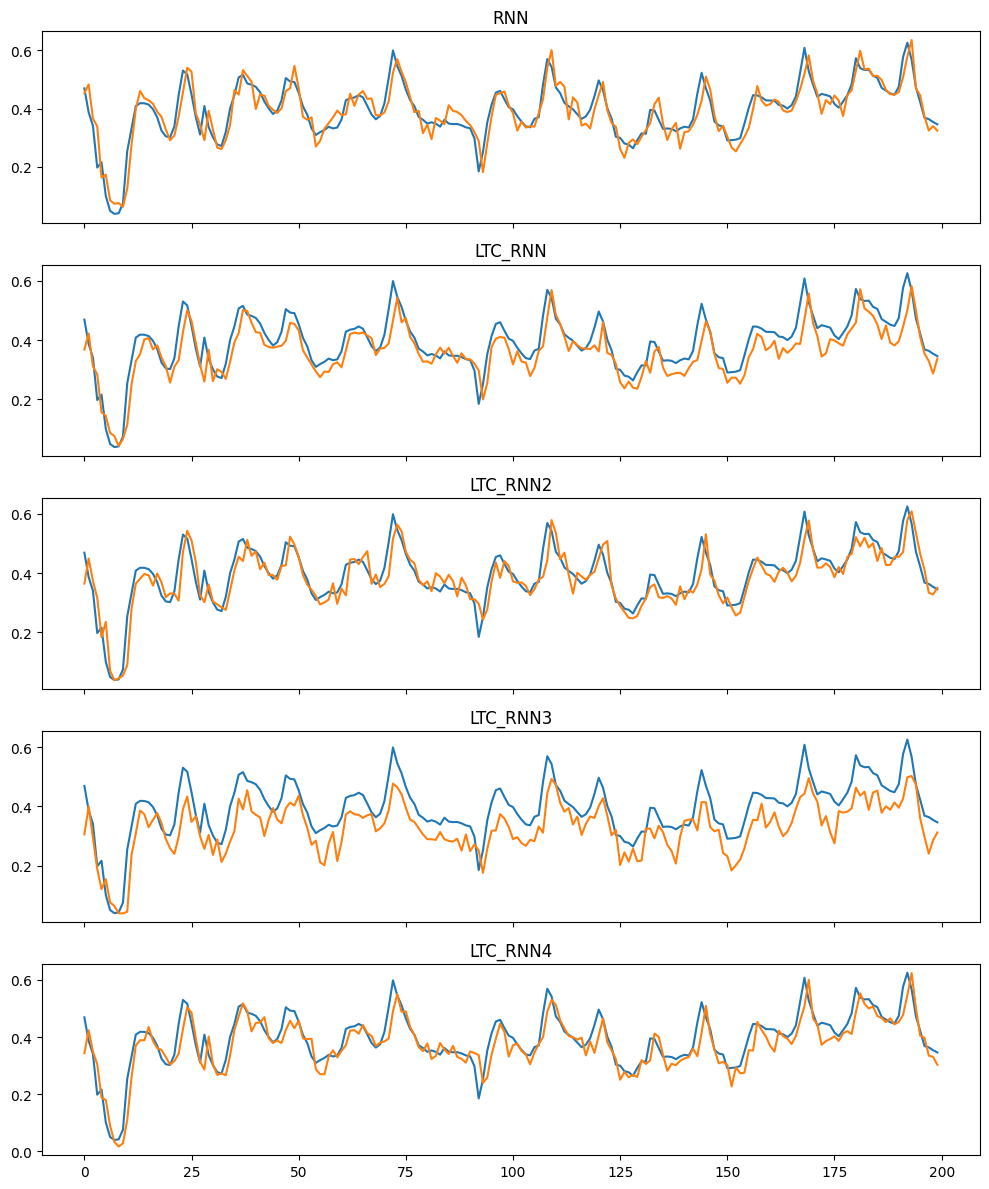

In [57]:

fr = 0
to = 200

fig, axs = plt.subplots(5, 1, figsize=(10, 12), sharex=True)

axs[0].plot(test_dataset["y"][fr:to].cpu(), label="Original")
axs[0].plot(r[fr:to], label="RNN")
axs[0].set_title("RNN")

axs[1].plot(test_dataset["y"][fr:to].cpu(), label="Original")
axs[1].plot(l[fr:to], label="LTC_RNN")
axs[1].set_title("LTC_RNN")

axs[2].plot(test_dataset["y"][fr:to].cpu(), label="Original")
axs[2].plot(l2[fr:to], label="LTC_RNN2")
axs[2].set_title("LTC_RNN2")

axs[3].plot(test_dataset["y"][fr:to].cpu(), label="Original")
axs[3].plot(l3[fr:to], label="LTC_RNN3")
axs[3].set_title("LTC_RNN3")


axs[4].plot(test_dataset["y"][fr:to].cpu(), label="Original")
axs[4].plot(l4[fr:to], label="LTC_RNN4")
axs[4].set_title("LTC_RNN4")


plt.tight_layout()
plt.show()

In [61]:
print( f"RNN: {torch.var_mean( first_rows - r)}" )
print( f"LTC_RNN: {torch.var_mean( first_rows - l)}" )
print( f"LTC_RNN2: {torch.var_mean( first_rows - l2)}" )
print( f"LTC_RNN3: {torch.var_mean( first_rows - l3)}" )
print( f"LTC_RNN4: {torch.var_mean( first_rows - l4)}" )

RNN: (tensor(0.0013), tensor(-0.0047))
LTC_RNN: (tensor(0.0010), tensor(0.0207))
LTC_RNN2: (tensor(0.0011), tensor(0.0031))
LTC_RNN3: (tensor(0.0020), tensor(0.0558))
LTC_RNN4: (tensor(0.0011), tensor(0.0077))
